## Importing libraries

In [1]:
import os
import cv2
import numpy as np
from  matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from collections import Counter
import keras_tuner
from keras_tuner.tuners import RandomSearch

## Preparing the training dataset

In [2]:
ds_train = r"C:\Users\badullah\Downloads\Jupyter Notebook\ct\train"

classes = {"normal": 0, "benign": 1, "malignant": 2} 

In [3]:
# Get list of all image file names 

ds_train_images = [] 

for key in classes.keys(): 

    folder = os.path.join(ds_train, key) 

    images = os.listdir(folder) 

    for img in images: 

        ds_train_images.append(os.path.join(folder, img)) 

In [4]:
# Create empty arrays for data and labels 

train_data = [] 

train_label = [] 

In [5]:
# Loop over all image file names, read images, preprocess them and store in data array 

for img in ds_train_images: 

    image = cv2.imread(img) 

    # Resize image to desired size
    
    image = cv2.resize(image, (224, 224))  

    # Normalize pixel values
    
    image = image.astype("float32") / 255.0 
    
    # convert the image to grayscale

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # append the image to the array

    train_data.append(image) 
    
    # Get corresponding label for image from folder name 

    label = img.split(os.path.sep)[-2] 

    label = classes[label] 

    train_label.append(label)

In [6]:
# Convert data and labels to numpy arrays 

train_images = np.array(train_data) 

train_labels = np.array(train_label)

## Preparing the testing dataset

In [7]:
# set the path of the testing folder 

ds_test = r"C:\Users\badullah\Downloads\Jupyter Notebook\ct\test"

#categories = ['test']

In [8]:
# create an empty array to store test images 

test_data = [] 

test_label = []

In [9]:
# loop through the testing folder to read the images 

for img in os.listdir(ds_test): 

    # read the image file 

    image_path = os.path.join(ds_test, img) 

    image = cv2.imread(image_path) 

    # resize the image to the desired size

    image = cv2.resize(image, (224, 224)) 
    
    # Normalize pixel values
    
    image = image.astype("float32") / 255.0
    
    # convert the image to grayscale

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

    # append the image to the array 

    test_data.append(image) 
    
    # Get corresponding label for image from folder name 

    label = 0

    test_label.append(label)    

In [10]:
# convert the array of images to a numpy array 

test_images = np.array(test_data) 

test_labels = np.array(test_label)

## Checking infos about training and testing data

In [11]:
# print the shape of the train data

print(train_images.shape)
print(train_labels.shape)
print(Counter(train_labels))
print(train_images.dtype)

(1097, 224, 224)
(1097,)
Counter({2: 561, 0: 416, 1: 120})
float32


In [12]:
# print the shape of the test data

print(test_images.shape)
print(test_labels.shape)
print(Counter(test_labels))
print(test_images.dtype)

(197, 224, 224)
(197,)
Counter({0: 197})
float32


## Train a model using basic approach

In [13]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(512, input_shape=(224, 224, 1), activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=32)

Epoch 1/5
35/35 [==============================] - 16s 400ms/step - loss: 10.7865 - accuracy: 0.5242
Epoch 2/5
35/35 [==============================] - 14s 405ms/step - loss: 1.1818 - accuracy: 0.7010
Epoch 3/5
35/35 [==============================] - 15s 417ms/step - loss: 0.3708 - accuracy: 0.8596
Epoch 4/5
35/35 [==============================] - 15s 419ms/step - loss: 0.1889 - accuracy: 0.9289
Epoch 5/5
35/35 [==============================] - 15s 418ms/step - loss: 0.1058 - accuracy: 0.9617


In [14]:
# Evaluating the Keras model

model.evaluate(test_images, test_labels)

7/7 [==============================] - 0s 30ms/step - loss: 3.4465 - accuracy: 0.2843


[3.4464762210845947, 0.2842639684677124]

## CNN modelling

In [15]:
model = keras.Sequential([
    keras.layers.Conv2D(64, 3, input_shape=(224, 224, 1), activation='relu'),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=32)

Epoch 1/5
35/35 [==============================] - 149s 4s/step - loss: 1.7872 - accuracy: 0.7402
Epoch 2/5
35/35 [==============================] - 161s 5s/step - loss: 0.0542 - accuracy: 0.9845
Epoch 3/5
35/35 [==============================] - 156s 4s/step - loss: 0.0244 - accuracy: 0.9954
Epoch 4/5
35/35 [==============================] - 158s 4s/step - loss: 0.0086 - accuracy: 0.9982
Epoch 5/5
35/35 [==============================] - 155s 4s/step - loss: 0.0194 - accuracy: 0.9945


In [16]:
# Evaluating the Keras model

model.evaluate(test_images, test_labels)

7/7 [==============================] - 7s 909ms/step - loss: 5.5778 - accuracy: 0.3046


[5.577820301055908, 0.3045685291290283]

In [17]:
# Improving the model

model = keras.Sequential([
    keras.layers.AveragePooling2D(6, 3, input_shape=(224, 224, 1)),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=32)

Epoch 1/5
35/35 [==============================] - 22s 592ms/step - loss: 0.9820 - accuracy: 0.5460
Epoch 2/5
35/35 [==============================] - 21s 610ms/step - loss: 0.6748 - accuracy: 0.7101
Epoch 3/5
35/35 [==============================] - 22s 617ms/step - loss: 0.4243 - accuracy: 0.8286
Epoch 4/5
35/35 [==============================] - 22s 619ms/step - loss: 0.2541 - accuracy: 0.9198
Epoch 5/5
35/35 [==============================] - 21s 601ms/step - loss: 0.1442 - accuracy: 0.9608


In [18]:
# Evaluating the Keras model

model.evaluate(test_images, test_labels)

7/7 [==============================] - 1s 143ms/step - loss: 1.7454 - accuracy: 0.4619


[1.7453908920288086, 0.46192893385887146]

## Hyperparameter Tuning

In [19]:
def build_model(hp):
    
    model = keras.Sequential()
    
    model.add(keras.layers.AveragePooling2D(6, 3, input_shape=(224, 224, 1)))
    
    for i in range(hp.Int("Conv layer", min_value=0, max_value=3)):
        model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [16, 32, 64]), 3, activation='relu'))
    
    model.add(keras.layers.MaxPool2D(2, 2))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(hp.Choice("Dense layer", [64, 128, 256, 512, 1024]), activation='relu'))
    
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials=5,
    directory='./new_directory1'
)

history=tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32)

Trial 5 Complete [00h 01m 47s]
val_accuracy: 0.4771573543548584

Best val_accuracy So Far: 0.7868020534515381
Total elapsed time: 00h 12m 37s
INFO:tensorflow:Oracle triggered exit


In [20]:
best_model = tuner.get_best_models()[0]

In [21]:
best_model.evaluate(test_images, test_labels)

7/7 [==============================] - 1s 48ms/step - loss: 0.6337 - accuracy: 0.7868


[0.6337093114852905, 0.7868020534515381]

In [22]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (AverageP  (None, 73, 73, 1)        0         
 ooling2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 1)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 36, 1)         0         
                                                                 
 flatten (Flatten)           (None, 1296)              0         
                                                                 
 dense (Dense)               (None, 1024)              1328128   
                                                                 
 dense_1 (Dense)             (None, 3)                 3

In [23]:
tuner.results_summary()

Results summary
Results in ./new_directory1\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
Conv layer: 0
Dense layer: 1024
Score: 0.7868020534515381

Trial 2 summary
Hyperparameters:
Conv layer: 3
Dense layer: 256
layer_0_filters: 16
layer_1_filters: 16
layer_2_filters: 16
Score: 0.4822334945201874

Trial 4 summary
Hyperparameters:
Conv layer: 2
Dense layer: 128
layer_0_filters: 16
layer_1_filters: 32
layer_2_filters: 16
Score: 0.4771573543548584

Trial 3 summary
Hyperparameters:
Conv layer: 3
Dense layer: 128
layer_0_filters: 32
layer_1_filters: 64
layer_2_filters: 64
Score: 0.42131978273391724

Trial 1 summary
Hyperparameters:
Conv layer: 2
Dense layer: 64
layer_0_filters: 16
layer_1_filters: 16
Score: 0.3045685291290283


## Plot image from Numpy Array

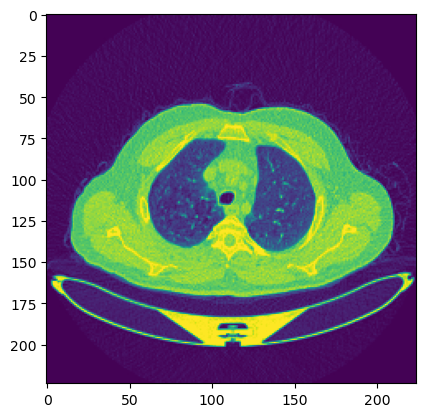

In [24]:
plt.imshow(train_images[0])

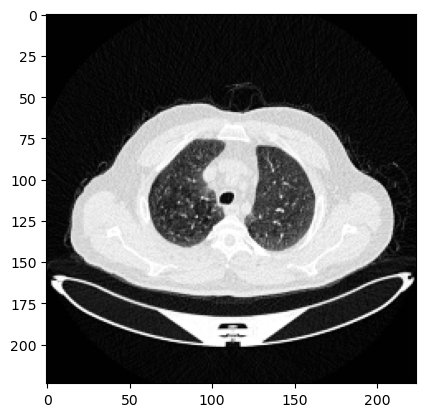

In [25]:
plt.imshow(train_images[0], cmap='Greys_r')

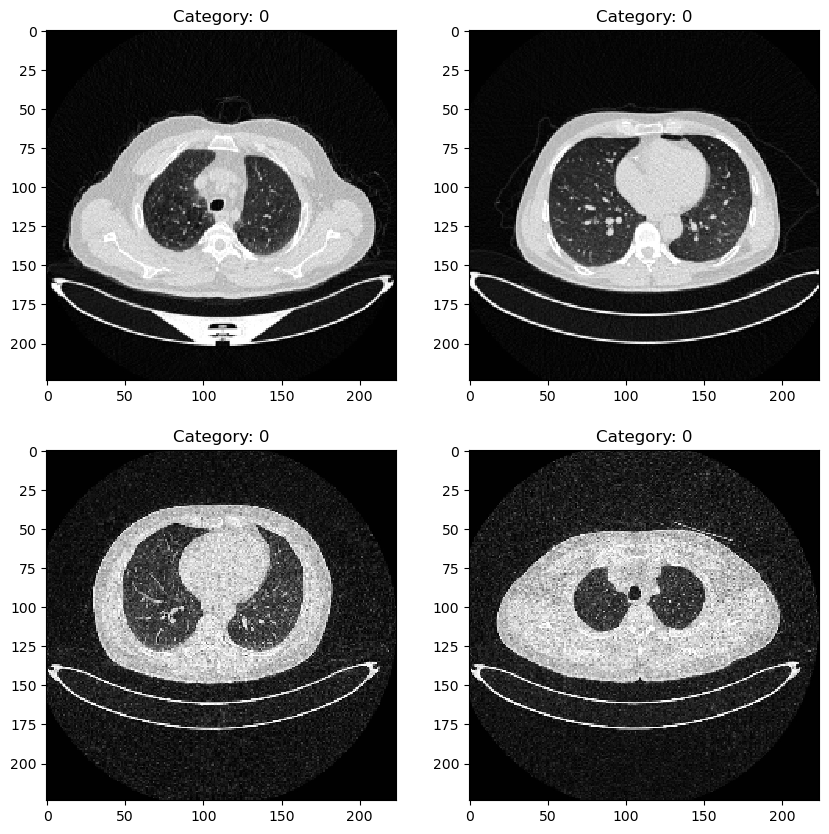

In [26]:
# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(10,10))

# Display the first image in the top-left subplot
ax[0, 0].imshow(train_images[0], cmap='gray', interpolation='nearest')
ax[0, 0].set_title('Category: {}'.format(train_labels[0]))

# Display the second image in the top-right subplot
ax[0, 1].imshow(train_images[1], cmap='gray', interpolation='nearest')
ax[0, 1].set_title('Category: {}'.format(train_labels[1]))

# Display the third image in the bottom-left subplot
ax[1, 0].imshow(train_images[2], cmap='gray', interpolation='nearest')
ax[1, 0].set_title('Category: {}'.format(train_labels[2]))

# Display the fourth image in the bottom-right subplot
ax[1, 1].imshow(train_images[3], cmap='gray', interpolation='nearest')
ax[1, 1].set_title('Category: {}'.format(train_labels[3]))

# Show the plot
plt.show()